# Analysis of Predicting gene expression using millions of random promoter sequences DREAM Challenge 2022
![DREAM_banner](images/DREAM_banner.png)
We have measured promoter-driven expression in the yeast S. cerevisiae using Gigantic Parallel Reporter Assay (de Boer et al. 2020), in which 80 bp of random DNA are inserted within a promoter construct and the resulting expression is measured. Each random promoter is cloned into an episomal low-copy-number yellow fluorescent protein (YFP) expression vector that also contains a constitutive Red Fluorescent Protein (RFP). The library of vectors is transformed into yeast, the yeast is grown in the desired medium, and expression is then measured. Expression is measured by sorting the yeast into 18 expression bins by the log ratio of YFP: RFP, which controls for extrinsic noise that affects both fluorescent genes (e.g. bigger cells have more YFP because they are bigger, but since they have more RFP as well, we can remove this extrinsic signal). The yeast sorted into each bin is grown, the vectors are isolated, and the promoter sequences are amplified by PCR and sequenced using high-throughput sequencing. At the end of each experiment, we obtain a table of promoter sequences (read off the sequencer) and expression levels (corresponding to the sorting bin in which the promoter sequence was observed, or a weighted average if it was seen in more than one bin).

To prevent biases towards existing sequences, we assessed the expression of 80-bp random DNA sequences, in which, during synthesis, each base is randomly picked from the four bases. For this competition, yeast was grown in Chardonnay grape must (grape juice that could be fermented into Chardonnay wine).


In [1]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

# Python imports for analysis
import numpy as np
import pandas as pd
import eugene as eu

# Configure EUGENe 
print(eu.__version__)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/promoter_prediction22"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/promoter_prediction22"
eu.settings.dl_num_workers = 0
eu.settings.batch_size = 2048

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000
0.1.0


# Dataloading

In [2]:
# Load the dataset from the module, takes about 25s
sdata_train = eu.dl.read_csv("/cellar/users/aklie/data/eugene/predicting_promoters22/train_sequences.txt", seq_col="sequence", target_col="expression", col_names=["sequence", "expression"])
sdata_train

SeqData object with = 6739257 seqs
seqs = (6739257,)
names = (6739257,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'target'
pos_annot: None
seqsm: None
uns: None

# Preprocessing

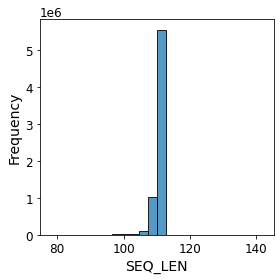

In [3]:
# Get and plot the distrubution on sequence length, takes about 15s 
sdata_train["SEQ_LEN"] = [len(seq) for seq in sdata_train.seqs]
eu.pl.histplot(sdata_train, keys="SEQ_LEN", orient="h")

In [4]:
sdata_train = sdata_train[sdata_train["SEQ_LEN"] == 110]

In [5]:
# Add reverse complement, ohe and training labels, takes about 
eu.pp.train_test_split_data(sdata_train)
sdata_train

SeqData object modified:
    seqs_annot:
        + TRAIN


SeqData object with = 5529183 seqs
seqs = (5529183,)
names = (5529183,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'target', 'SEQ_LEN', 'TRAIN'
pos_annot: None
seqsm: None
uns: None

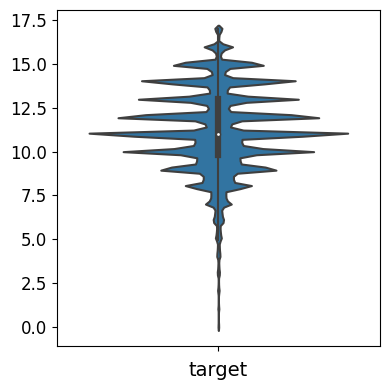

In [6]:
# Check the distribution of the targets
eu.pl.violinplot(sdata_train, keys="target")

# Training

In [7]:
# Instantiate a simple CNN that 
model = eu.models.load_config("CNN", "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/predicting_promoters22/ssCNN_reg.yaml")
eu.models.base.init_weights(model)
model.loss_fxn

<function torch.nn.functional.mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Union[bool, NoneType] = None, reduce: Union[bool, NoneType] = None, reduction: str = 'mean') -> torch.Tensor>

In [8]:
# Train the model for 10 epochs
eu.train.fit(
    model=model, 
    sdata=sdata_train, 
    gpus=1, 
    target="target",
    seq_transforms="one_hot_encode",
    train_key="TRAIN",
    epochs=10,
    version="test"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | convnet   | BasicConv1D               | 12.4 K
2 | fcnet     | BasicFullyConnectedModule | 2.2 M 
--------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.713     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 13
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.231


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 3.162


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 3.121


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 3.083


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 3.077


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 3.077


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 3.057


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 3.041


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

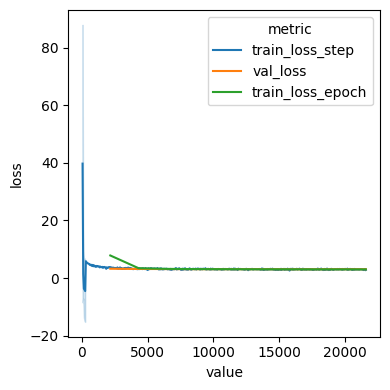

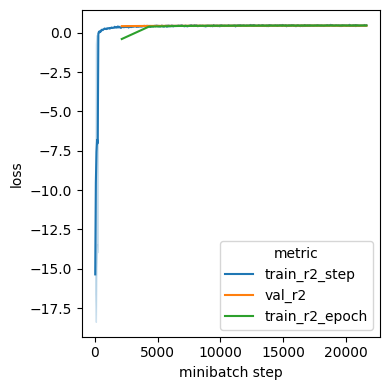

In [10]:
# Output training summary
eu.pl.training_summary("/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/promoter_prediction22/ssCNN_regression/test/", metrics="r2")

# Evaluation

In [31]:
eu.predict.train_val_predictions(
    model,
    sdata=sdata_train,
    target="target",
    train_key="TRAIN",
    seq_transforms="one_hot_encode",
    version="test"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

: 

: 

In [ ]:
# Plot the performance scatterplot on the training and validation set
val_idx = np.where(sdata_train["TRAIN"] == False)[0]
train_idx = np.where(sdata_train["TRAIN"] == True)[0]
eu.pl.performance_scatter(
    sdata_train, 
    seq_idx=train_idx, 
    target="target", 
    prediction="target_predictions",
    title="Training set performance",
    alpha=0.5
)
eu.pl.performance_scatter(
    sdata_train, 
    seq_idx=val_idx, 
    target="target", 
    prediction="target_predictions",
    title="Validation set performance",
    color="orange",
    alpha=0.5
)

In [11]:
# Load the dataset from the module, takes about 25s
sdata_test = eu.dl.read_csv("/cellar/users/aklie/data/eugene/predicting_promoters22/test_sequences.txt", seq_col="sequence", target_col="expression", col_names=["sequence", "expression"])
sdata_test

SeqData object with = 71102 seqs
seqs = (71102,)
names = (71102,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'target'
pos_annot: None
seqsm: None
uns: None

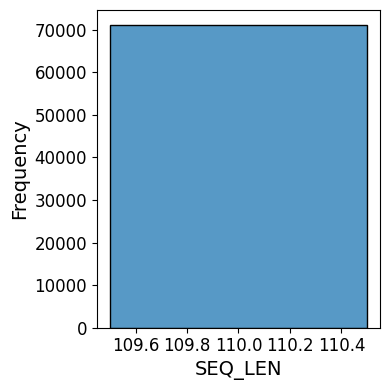

In [13]:
# Get and plot the distrubution on sequence length, takes about 15s 
sdata_test["SEQ_LEN"] = [len(seq) for seq in sdata_test.seqs]
eu.pl.histplot(sdata_test, keys="SEQ_LEN", orient="h")

In [14]:
sdata_test = sdata_test[sdata_test["SEQ_LEN"] == 110]

In [15]:
eu.pp.one_hot_encode_data(sdata_test)

SeqData object modified:
	ohe_seqs: None -> 71102 ohe_seqs added


In [22]:
eu.pp.reverse_complement_data(sdata_test)

SeqData object modified:
	rev_seqs: None -> 71102 rev_seqs added


In [23]:
# Get train and validation predictions
eu.predict.predictions(
    model, 
    sdata=sdata_test, 
    target="target",
    version="test"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + target_predictions


In [27]:
sdata_test.seqs_annot

,target,SEQ_LEN,target_predictions
seq00000,NaN,110,11.044153
seq00001,NaN,110,11.032152
seq00002,NaN,110,10.568066
seq00003,NaN,110,11.853669
seq00004,NaN,110,10.929345
...,...,...,...
seq71097,NaN,110,14.902097
seq71098,NaN,110,14.428398
seq71099,NaN,110,13.807043
seq71100,NaN,110,13.746634


In [26]:
eu.pl.performance_scatter(
    sdata_test, 
    target="target",
    prediction="target_predictions",
    title="Test set performance",
    alpha=0.5
)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [21]:
eu.predict.predictions?

Signature:
eu.predict.predictions(
    model: pytorch_lightning.core.lightning.LightningModule,
    sdata: eugene.dataloading.dataloaders._SeqData.SeqData = None,
    target: Union[str, List[str]] = None,
    gpus: int = None,
    batch_size: int = None,
    num_workers: int = None,
    out_dir: os.PathLike = None,
    name: str = None,
    version: str = '',
    file_label: str = '',
    sdataset: eugene.dataloading.dataloaders._SeqDataset.SeqDataset = None,
    sdataloader: torch.utils.data.dataloader.DataLoader = None,
    seq_transforms: List = None,
    transform_kwargs={'transpose': True},
    copy: bool = False,
)
Docstring:
Predict on the model.

Params:
-------

model: LightningModule
   The model to predict on.
sdata: SeqData
   The data to predict on.
target: Union[str, List[str]]
   The target to predict on.
gpus: int
   The number of GPUs to use.
batch_size: int
   The batch size to use.
num_workers: int
   The number of workers to use.
out_dir: os.PathLike
   The director

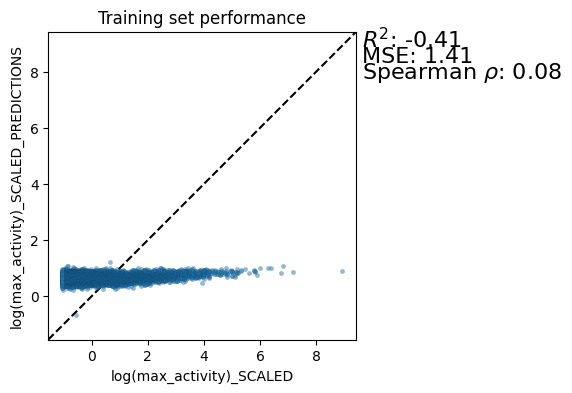

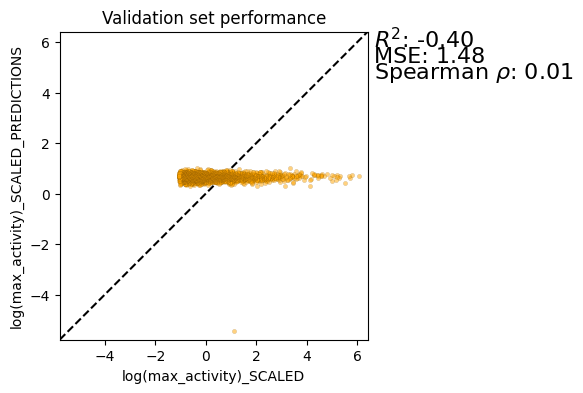

In [32]:
# Plot the performance scatterplot on the training and validation set
val_idx = np.where(sdata_train["TRAIN"] == False)[0]
train_idx = np.where(sdata_train["TRAIN"] == True)[0]
eu.pl.performance_scatter(
    sdata_train, 
    seq_idx=train_idx, 
    target="log(max_activity)_SCALED", 
    prediction="log(max_activity)_SCALED_PREDICTIONS",
    title="Training set performance",
    alpha=0.5
)
eu.pl.performance_scatter(
    sdata_train, 
    seq_idx=val_idx, 
    target="log(max_activity)_SCALED", 
    prediction="log(max_activity)_SCALED_PREDICTIONS",
    title="Validation set performance",
    color="orange",
    alpha=0.5
)

# Interpret 

In [134]:
eu.interpret.feature_attribution(model, sdata_train)

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/4 [00:00<?, ?it/s]

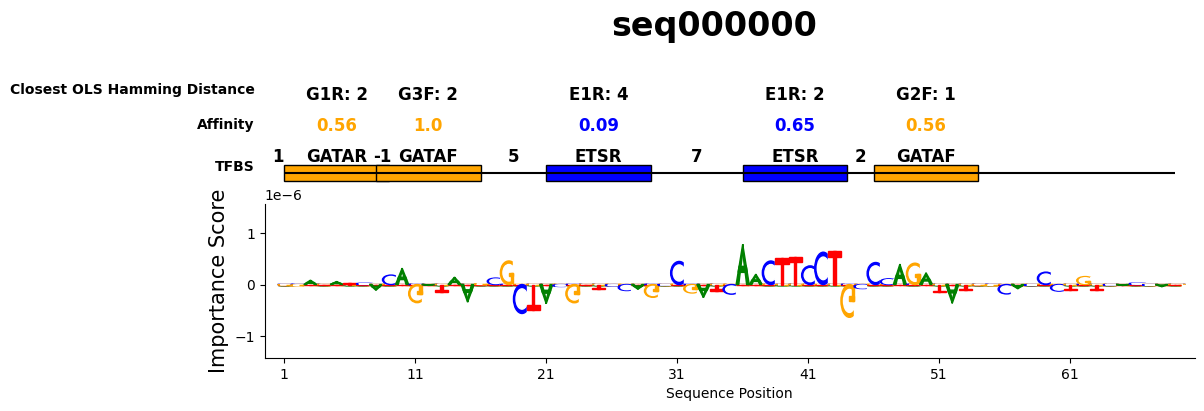

In [138]:
eu.pl.otx_seq(sdata_train, seq_id=sdata_train.names[0], uns_key="InputXGradient_imps")

In [149]:
eu.interpret.generate_pfms(model, sdata_train)

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/4 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/32 [00:00<?, ?it/s]

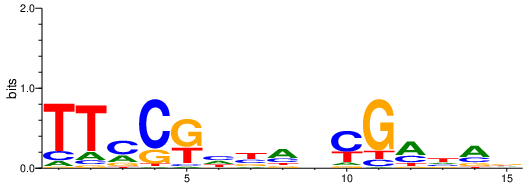

In [153]:
eu.pl.filter_viz(sdata_train, filter_id=0)

---

# Scratch

In [ ]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
tm_r2score = R2Score()
print(tm_r2score(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.r2_score(y_true, y_pred))

sdata_train = sdata_train[train_idx]
sdata_val = sdata_train[val_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(tm_r2score(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.r2_score(uno_x, dos_x))

tensor(0.9486)
0.9486081370449679
tensor(-17.8863)
0.16492233358169228


In [ ]:
import torch
from torchmetrics import R2Score
import sklearn.metrics

target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
print(model.loss_fxn(preds, target))

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(sklearn.metrics.mean_squared_error(y_true, y_pred))

sdata_train = sdata_train[train_idx]
uno = torch.tensor(sdata_train["log(max_activity)_SCALED"].values)
dos = torch.tensor(sdata_train["log(max_activity)_SCALED_PREDICTIONS"].values)
print(model.loss_fxn(uno, dos))

uno_x, dos_x = uno.numpy(), dos.numpy()
print(sklearn.metrics.mean_squared_error(uno_x, dos_x))

tensor(0.3750)
0.375
tensor(0.8351, dtype=torch.float64)
0.8350776664183077
